In [5]:
import os
import sys
import torch
import random
import argparse
import numpy as np
import scipy
from matplotlib import pyplot
import numpy

sys.path.append('../../timeseries/')
sys.path.append('../../timeseries/experiments_scripts/')
sys.path.append('../../src/')

import factors
import state_models
import observation_models
from ssm_em import StateSpaceEM
from nonlinear_ssm import NonLinearStateSpace_EM

from scipy.stats import norm
from scipy.stats import zscore
from ssm_em import StateSpaceEM, load_model
from sklearn.covariance import EmpiricalCovariance
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF

from exp_utils import *

def reset_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    

In [20]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te, x_te_na, s_tr_x = load_synthetic_e1()
t_tr = numpy.array([numpy.arange(x_tr.shape[0])]).T
t_va = numpy.array([numpy.arange(x_va.shape[0])]).T
t_te = numpy.array([numpy.arange(x_te.shape[0])]).T
x_tr, x_va, x_te = x_tr[:,:2], x_va[:,:1], x_te[:,:1]

In [82]:
import newt
import objax
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler

X = t_tr
Y = x_tr

# Standardize
Xall = X
Yall = Y
x_plot = np.linspace(np.min(Xall)-0.2, np.max(Xall)+0.2, 200)

# Load cross-validation indices
cvind = np.loadtxt('../Newt/newt/experiments/motorcycle/cvind.csv').astype(int)

# 10-fold cross-validation setup
nt = np.floor(cvind.shape[0]/10).astype(int)
cvind = np.reshape(cvind[:10*nt], (10, nt))

np.random.seed(123)
fold = 0

# Get training and test indices
test = cvind[fold, :]
train = np.setdiff1d(cvind, test)

# Set training and test data
X = Xall
Y = Yall
N = X.shape[0]
M = 20
batch_size = N  # 100
Z = np.linspace(np.min(Xall), np.max(Xall), M)

var_f1 = 1.  # GP variance
len_f1 = 1.  # GP lengthscale
var_f2 = 1.  # GP variance
len_f2 = 1.  # GP lengthscale

kern1 = newt.kernels.Matern32(variance=var_f1, lengthscale=len_f1)
kern2 = newt.kernels.Matern32(variance=var_f2, lengthscale=len_f2)
kern = newt.kernels.Independent([kern1, kern2])
#lik = newt.likelihoods.HeteroscedasticNoise()
lik = newt.likelihoods.Gaussian()
# model = newt.models.VariationalGP(kernel=kern, likelihood=lik, X=X, Y=Y)
model = newt.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=X, Y=Y)
# model = newt.models.SparseExpectationPropagationGP(kernel=kern, likelihood=lik, X=X, Y=Y, Z=Z)

lr_adam = 0.01
lr_newton = 0.05
iters = 200
opt_hypers = objax.optimizer.Adam(model.vars())
energy = objax.GradValues(model.energy, model.vars())
inf_args = {
    "power": 0.5,  # the EP power
}


@objax.Function.with_vars(model.vars() + opt_hypers.vars())
def train_op():
    model.inference(lr=lr_newton, **inf_args)  # perform inference and update variational params
    dE, E = energy(**inf_args)  # compute energy and its gradients w.r.t. hypers
    opt_hypers(lr_adam, dE)
    return E

In [83]:
Z

array([   0.        ,  236.78947368,  473.57894737,  710.36842105,
        947.15789474, 1183.94736842, 1420.73684211, 1657.52631579,
       1894.31578947, 2131.10526316, 2367.89473684, 2604.68421053,
       2841.47368421, 3078.26315789, 3315.05263158, 3551.84210526,
       3788.63157895, 4025.42105263, 4262.21052632, 4499.        ])

In [84]:
X.shape, Y.shape, model.obs_dim

((4500, 1), (4500, 2), 2)

In [85]:
train_op = objax.Jit(train_op)

t0 = time.time()
for i in range(1, iters + 1):
    loss = train_op()
    print('iter %2d, energy: %1.4f' % (i, loss[0]))
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))

t0 = time.time()
posterior_mean, posterior_var = model.predict(X=x_plot)
nlpd = model.negative_log_predictive_density(X=X, Y=Y)
t1 = time.time()
print('prediction time: %2.2f secs' % (t1-t0))
print('NLPD: %1.2f' % nlpd)


x_pred = x_plot
link = model.likelihood.link_fn
lb = posterior_mean[:, 0] - np.sqrt(posterior_var[:, 0] + link(posterior_mean[:, 1]) ** 2) * 1.96
ub = posterior_mean[:, 0] + np.sqrt(posterior_var[:, 0] + link(posterior_mean[:, 1]) ** 2) * 1.96
post_mean = posterior_mean[:, 0]
lb = lb
ub = ub

iter  1, energy: 37829.8814
iter  2, energy: 25913.7066
iter  3, energy: 20607.8950
iter  4, energy: 17631.4893
iter  5, energy: 15749.0861
iter  6, energy: 14467.2356
iter  7, energy: 13549.0856
iter  8, energy: 12866.6056
iter  9, energy: 12344.5745
iter 10, energy: 11935.9819
iter 11, energy: 11610.0143
iter 12, energy: 11345.6946
iter 13, energy: 11128.2945
iter 14, energy: 10947.2052
iter 15, energy: 10794.6190
iter 16, energy: 10664.6827
iter 17, energy: 10552.9387
iter 18, energy: 10455.9456
iter 19, energy: 10371.0136
iter 20, energy: 10296.0188
iter 21, energy: 10229.2681
iter 22, energy: 10169.4002
iter 23, energy: 10115.3131
iter 24, energy: 10066.1081
iter 25, energy: 10021.0483
iter 26, energy: 9979.5260
iter 27, energy: 9941.0377
iter 28, energy: 9905.1644
iter 29, energy: 9871.5560
iter 30, energy: 9839.9186
iter 31, energy: 9810.0052
iter 32, energy: 9781.6069
iter 33, energy: 9754.5470
iter 34, energy: 9728.6755
iter 35, energy: 9703.8646
iter 36, energy: 9680.0051
ite

plotting ...


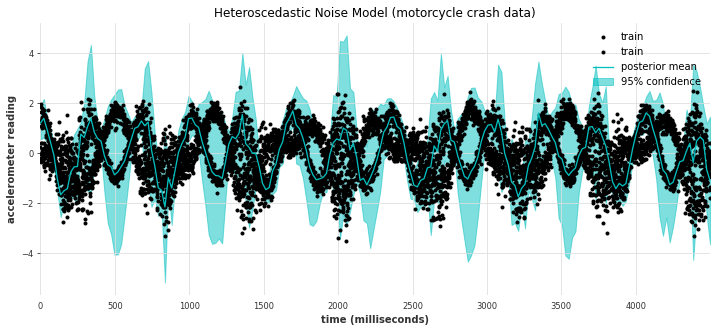

In [86]:
print('plotting ...')
plt.figure(1, figsize=(12, 5))
plt.clf()
plt.plot(X, Y[:,], 'k.', label='train')
plt.plot(x_pred, post_mean, 'c', label='posterior mean')
plt.fill_between(x_pred, lb, ub, color='c', alpha=0.5, label='95% confidence')
plt.xlim(x_pred[0], x_pred[-1])
if hasattr(model, 'Z'):
    plt.plot(X_scaler.inverse_transform(model.Z.value[:, 0]),
             (np.min(lb)-5)*np.ones_like(model.Z.value[:, 0]),
             'c^',
             markersize=4)
plt.legend()
plt.title('Heteroscedastic Noise Model (motorcycle crash data)')
plt.xlabel('time (milliseconds)')
plt.ylabel('accelerometer reading')
plt.show()


In [40]:
model.func_dim

2

In [87]:
mean_tr, std_tr = model.predict_y(t_tr, R=2000)
lb, ub = mean_tr - 1.96 * std_tr, mean_tr + 1.96 * std_tr

plotting ...


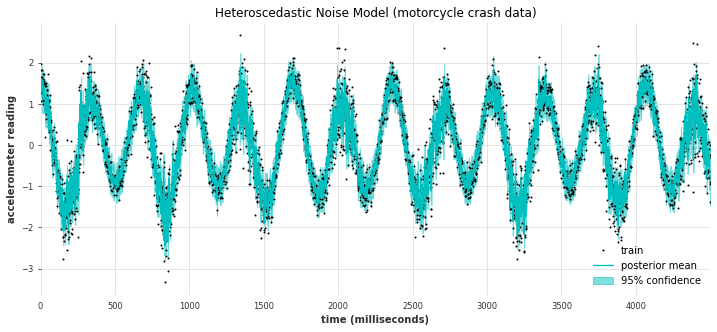

In [88]:
print('plotting ...')
plt.figure(1, figsize=(12, 5))
plt.clf()
plt.plot(X, Y[:,0], 'k.', label='train', ms=2)
plt.plot(t_tr, mean_tr[:,0], 'c', label='posterior mean')
plt.fill_between(t_tr[:,0], lb[:,0], ub[:,0], color='c', alpha=0.5, label='95% confidence')
plt.xlim(x_pred[0], x_pred[-1])
plt.legend()
plt.title('Heteroscedastic Noise Model (motorcycle crash data)')
plt.xlabel('time (milliseconds)')
plt.ylabel('accelerometer reading')
plt.show()


plotting ...


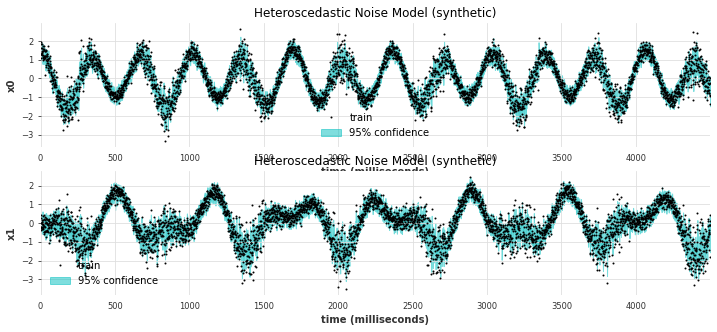

In [89]:
idx = 1
print('plotting ...')
plt.figure(1, figsize=(12, 5))
plt.clf()
for idx in range(2):
    plt.subplot(2,1,idx + 1)
    plt.plot(X, Y[:,idx], 'k.', label='train', ms=2)
    #plt.plot(t_tr, mean_tr[:,idx], 'c', label='posterior mean')
    plt.fill_between(t_tr[:,0], lb[:,idx], ub[:,idx], color='c', alpha=0.5, label='95% confidence')
    plt.xlim(x_pred[0], x_pred[-1])
    plt.legend()
    plt.title('Heteroscedastic Noise Model (synthetic)')
    plt.xlabel('time (milliseconds)')
    plt.ylabel('x%d' %(idx))
plt.show()


In [49]:
model.predict_y()

Signature: model.predict_y(X, R=None, cubature=None)
Docstring:
predict y at new test locations X
TODO: check non-Gaussian likelihoods
File:      /work/gaussian-toolbox/timeseries/Newt/newt/basemodels.py
Type:      method


In [61]:
mean_tr.shape

(4500, 2)

In [67]:
lb.shape

(4500, 2)